In [17]:
import yfinance as yf
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
from datetime import datetime

In [18]:
def fetch_options_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    options_dates = ticker.options
    # We'll use the nearest expiry date for our analysis
    options_data = ticker.option_chain(options_dates[0])
    return options_data.calls, options_data.puts



In [19]:
# Example usage:
gs_calls, gs_puts = fetch_options_data('GS')
print(gs_calls, gs_puts)

       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   GS250103C00300000 2024-12-24 16:09:26+00:00   300.0     278.85  273.45   
1   GS250103C00482500 2024-12-23 16:24:16+00:00   482.5      85.94   90.65   
2   GS250103C00485000 2024-12-23 16:24:16+00:00   485.0      83.44   88.80   
3   GS250103C00487500 2024-12-20 16:44:49+00:00   487.5      84.10   86.10   
4   GS250103C00500000 2024-12-30 20:51:37+00:00   500.0      75.56   73.40   
5   GS250103C00505000 2024-12-31 16:31:34+00:00   505.0      68.03   67.85   
6   GS250103C00510000 2024-11-21 17:25:30+00:00   510.0      87.00   54.20   
7   GS250103C00525000 2024-12-16 20:47:19+00:00   525.0      64.37   47.95   
8   GS250103C00535000 2024-12-31 17:13:39+00:00   535.0      37.97   38.50   
9   GS250103C00540000 2024-12-31 17:14:29+00:00   540.0      33.00   33.70   
10  GS250103C00545000 2025-01-02 15:28:01+00:00   545.0      34.35   28.15   
11  GS250103C00550000 2025-01-02 14:54:08+00:00   550.0      31.

In [20]:
gs_stock_data = yf.download('GS', start='2020-01-01', end=datetime.now().strftime('%Y-%m-%d'))


[*********************100%***********************]  1 of 1 completed


In [21]:
gs_stock_data.head

<bound method NDFrame.head of Price            Close        High         Low        Open   Volume
Ticker              GS          GS          GS          GS       GS
Date                                                               
2020-01-02  207.329208  207.612341  203.648386  204.391625  3736300
2020-01-03  204.904816  205.816171  203.772257  204.922516  2274500
2020-01-06  207.001785  207.063729  203.055531  203.444837  3329300
2020-01-07  208.364426  210.381796  207.718503  207.930863  5255200
2020-01-08  210.372940  212.133721  208.355569  208.532529  3564700
...                ...         ...         ...         ...      ...
2024-12-26  581.229980  582.590027  577.500000  578.150024  1092000
2024-12-27  576.179993  581.960022  571.349976  577.000000  1486000
2024-12-30  573.549988  576.020020  565.099976  567.270020  1265900
2024-12-31  572.619995  576.919983  570.400024  575.070007  1055800
2025-01-02  574.969971  584.309998  569.739990  579.309998  2219000

[1259 rows x 5 co

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(gs_stock_data['Close'])
plt.title('GS Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)

In [23]:
class BlackScholesModel:
    def __init__(self, S, K, T, r, sigma):
        self.S = S        # Underlying asset price
        self.K = K        # Option strike price
        self.T = T        # Time to expiration in years
        self.r = r        # Risk-free interest rate
        self.sigma = sigma  # Volatility of the underlying asset

    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def call_option_price(self):
        return (self.S * si.norm.cdf(self.d1(), 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def put_option_price(self):
        return (self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.d1(), 0.0, 1.0))


In [24]:
bsm = BlackScholesModel(S=100, K=100, T=1, r=0.05, sigma=0.2)
print(f"Call Option Price: {bsm.call_option_price()}")
print(f"Put Option Price: {bsm.put_option_price()}")

def calculate_historical_volatility(stock_data, window=252):
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    volatility = np.sqrt(window) * log_returns.std()
    return volatility

gs_volatility = calculate_historical_volatility(gs_stock_data)
print(f"GS Historical Volatility: {gs_volatility}")

Call Option Price: 10.450583572185565
Put Option Price: 5.573526022256971
GS Historical Volatility: Ticker
GS    0.330371
dtype: float64


In [25]:
class BlackScholesGreeks(BlackScholesModel):
    def delta_call(self):
        return si.norm.cdf(self.d1(), 0.0, 1.0)

    def delta_put(self):
        return -si.norm.cdf(-self.d1(), 0.0, 1.0)
    
    def gamma(self):
        return si.norm.pdf(self.d1(), 0.0, 1.0) / (self.S * self.sigma * np.sqrt(self.T))

    def theta_call(self):
        return (-self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * self.sigma / (2 * np.sqrt(self.T)) - self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def theta_put(self):
        return (-self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * self.sigma / (2 * np.sqrt(self.T)) + self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0))

    def vega(self):
        return self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * np.sqrt(self.T)
    
    def rho_call(self):
        return self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0)
    
    def rho_put(self):
        return -self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0)


In [26]:
bsg = BlackScholesGreeks(S=100, K=100, T=1, r=0.05, sigma=0.2)
print(f"Call Delta: {bsg.delta_call()}")
print(f"Put Delta: {bsg.delta_put()}")

Call Delta: 0.6368306511756191
Put Delta: -0.3631693488243809


In [27]:
stock_prices = np.linspace(80, 120, 100)
deltas = [BlackScholesGreeks(S=price, K=100, T=1, r=0.05, sigma=0.2).delta_call() for price in stock_prices]

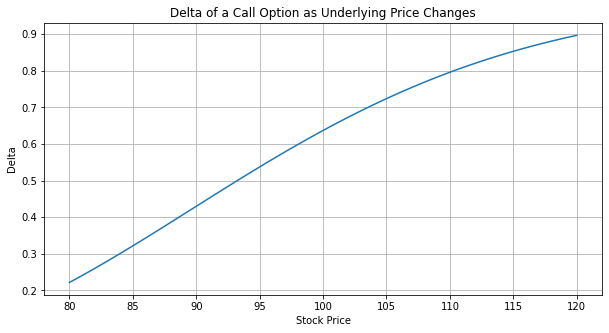

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(stock_prices, deltas)
plt.title('Delta of a Call Option as Underlying Price Changes')
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.grid(True)

In [29]:
def plot_option_sensitivity(bs_model, parameter, values, option_type='call'):
    prices = []
    for value in values:
        setattr(bs_model, parameter, value)
        if option_type == 'call':
            prices.append(bs_model.call_option_price())
        else:
            prices.append(bs_model.put_option_price())

    plt.figure(figsize=(10, 5))
    plt.plot(values, prices)
    plt.title(f'Option Price Sensitivity to {parameter.capitalize()}')
    plt.xlabel(parameter.capitalize())
    plt.ylabel('Option Price')
    plt.grid(True)

In [30]:
volatilities = np.linspace(0.1, 0.3, 100)
plot_option_sensitivity(bsm, 'sigma', volatilities, 'call')